## Reconstructing images from few pixels

In [2]:
from pit import *

# packages for reading the image
import scipy.ndimage as spimg
import glob
import os
import imageio


### ===============================================
### ---------- set image folder -------------------
folder = "/Users/Martin/Pictures/Camera Roll/"
### -----------------------------------------------

# all jpg files in folder
list_camera_pics = glob.glob(folder+'*.jpg') 
# file name of latest one
list_camera_pics=sorted(list_camera_pics, key=os.path.getctime) 
pic_file = list_camera_pics[-1] 

### -----------------------------------------------
### ---- OR choose picture from the repository ----
pic_file = "./pics/marie_curie.jpg"
### ===============================================


# read image
Xorig = imageio.imread(pic_file, as_gray=True)

# pywt can change the size -> easy fix by transforming back and forth
x = pywt.wavedec2(Xorig, wavelet='db1', level=1)
Xorig = pywt.waverec2(x, wavelet='db1')

# picture size
shape = Xorig.shape
n = np.prod(shape)

# choice of WT parameters
# choose frame
wlet = 'db12'
# wlet = 'coif12'
# wlet = 'sym12'
# print(pywt.wavelist(kind='discrete'))
L = 3 
# amplification of lower level wavelet coefficients
amp = np.linspace(1,.2,L)
amp = np.kron(amp, np.ones(3) )
amp = np.insert(amp,0, 20 ) #prepend -> for approximation coeffcient

### A compression test 

Relative compression error: 0.04805305600166321
Original image:


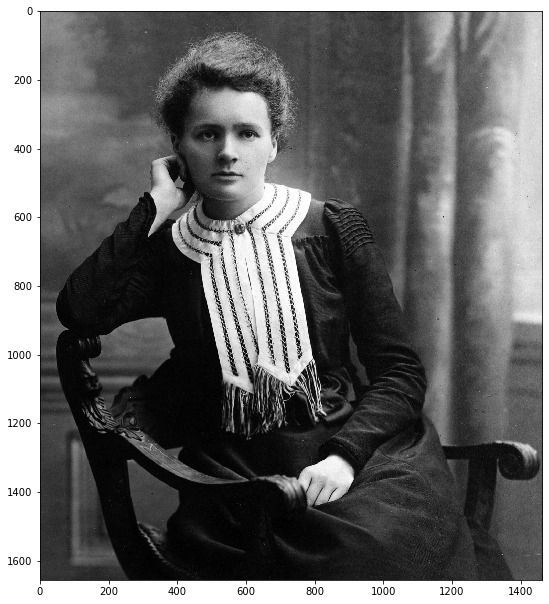

Compressed image (down to 121053 coefficients out of 2421072):


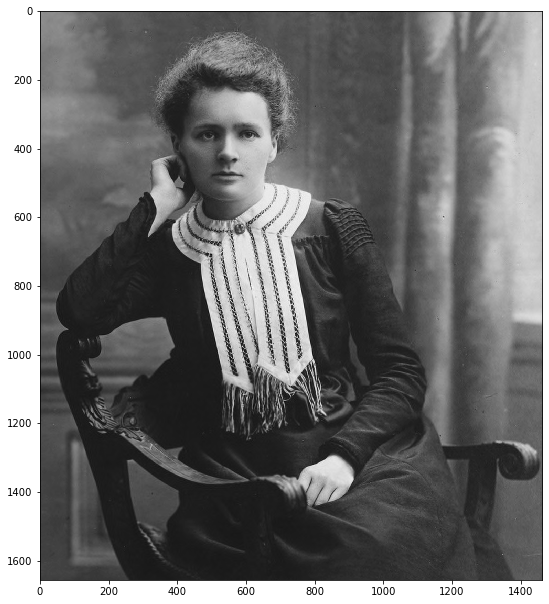

In [3]:
## (not necessary for the rest)
# choose basis for compression              
T = WT(shape, wavelet=wlet,level=L, amplify=amp)

# hard TO
s = int( np.prod(shape)/20 )
TO = hardTO(s)

# compression test
cXorig = compress(T,TO,Xorig)

print("Original image:")
pltPic(Xorig)

print("Compressed image (down to {} coefficients out of {}):".format(s,n) )
pltPic(cXorig)

### Set number of pixels to keep

Total number of pixels: 2421k
Number of remaining pixels: 121k


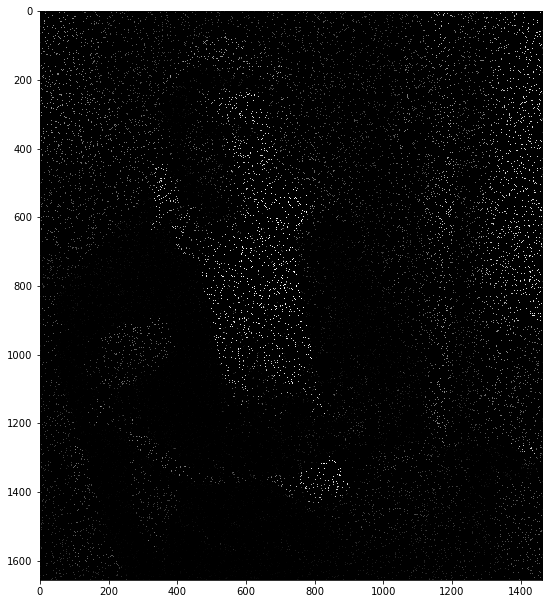

In [4]:
# set relative number of pixels
p = .05

# total number of pixels
m = int(p*n)
print("Total number of pixels: {}k".format(int(np.prod(Xorig.shape)/1000)))
print("Number of remaining pixels: {}k".format( int(m/1000) ))

# generate subsampled picture
mask = getRandMask(n, m)
Xsub = np.zeros(shape)
Xsub.flat[mask] = Xorig.flat[mask]
pltPic(Xsub)

### Choose parameters and run reconstruction

Relative error (support change): 0.975,  (1663468), 0.848 
Relative error (support change): 0.702,  (2443708), 0.518 (39606), 0.338 
Relative error (support change): 0.258,  (2305645), 0.209 
Relative error (support change): 0.177,  (2494820), 0.154 (2223), 0.140 
Relative error (support change): 0.137,  (2336985), 0.134 
Relative error (support change): 0.142,  (2493885), 0.130 (2381), 0.127 
Relative error (support change): 0.129,  (2289489), 0.127 
Relative error (support change): 0.136,  (2490778), 0.126 (3765), 0.125 
Relative error (support change): 0.126,  (2208346), 0.124 
Relative error (support change): 0.130,  (2483877), 0.123 (6807), 0.123 
Relative error (support change): 0.124,  (2049111), 0.121 
Relative error (support change): 0.124,  (2455335), 0.120 (19874), 0.120 
Relative error (support change): 0.121,  (2054622), 0.120 
Relative error (support change): 0.124,  (2456165), 0.119 (19518), 0.120 


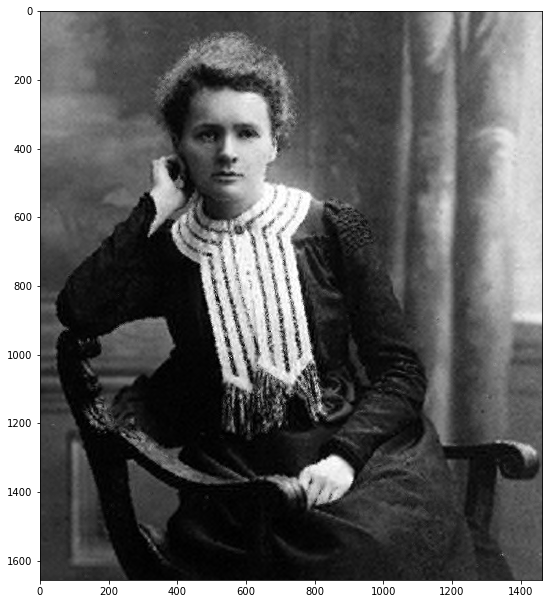

In [5]:
### schedule for DCT and WT iterations
steps_wt = 14
steps_dct = 10 #parameter for nr. of steps in fixed basis
N = 7 #nr. of switching bases: wt and dct

# threshold values
# th_dct = 3
# th_wt = 4
th_wt  = np.append( np.linspace(25,4,N-1), 4 )
th_dct = np.append( np.linspace(15,3,N-1), 3 )

# set initial guess for the reconstruction
if 'Xrec' not in locals():
    Xrec = Xsub
    
Xrec = Xsub

# set transformations
dct = DCT(shape)
wt = WT(shape, wavelet=wlet,level=L, amplify=amp)

#with myprofile.Profiler(fname='profile.dat'):
for j in range(N):
    thOp = softTO(th_dct[j])
    Xrec=FISTA(dct, thOp, mask, Xsub, stepsize = .75, n_steps=steps_dct, Xorig=Xorig, X0=Xrec)
    
    thOp = softTO(th_wt[j])
    Xrec=FISTA(wt, thOp, mask, Xsub, stepsize = .75, n_steps=steps_wt, Xorig=Xorig, X0=Xrec)

pltPic(Xrec)

### Compare to original picture

In [ ]:
pltPic(Xorig)

## Export images

In [7]:
# make black pixels in the masked picture Xsub white
Xsub2 = Xsub.copy()
Xsub2[Xsub2==0.0] = Xsub2.max()

imageio.imwrite("./pics/marie_curie_masked.jpg", Xsub2.astype(np.uint8))
imageio.imwrite("./pics/marie_curie_rec.jpg", Xrec.astype(np.uint8))